In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


# Time Series Analysis on Walmart Stock Data

In [50]:
data = pd.read_csv('WMT.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/3/2000,22.791668,23.000000,21.833332,22.270832,14.469358,25109700
1,1/4/2000,21.833332,21.937500,21.395832,21.437500,13.927947,20235300
2,1/5/2000,21.291668,21.458332,20.729168,21.000000,13.643703,21056100
3,1/6/2000,21.000000,21.520832,20.895832,21.229168,13.792585,19633500
4,1/7/2000,21.500000,22.979168,21.500000,22.833332,14.834813,23930700


In [51]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,22.791668,23.000000,21.833332,22.270832,14.469358,25109700
2000-01-04,21.833332,21.937500,21.395832,21.437500,13.927947,20235300
2000-01-05,21.291668,21.458332,20.729168,21.000000,13.643703,21056100
2000-01-06,21.000000,21.520832,20.895832,21.229168,13.792585,19633500
2000-01-07,21.500000,22.979168,21.500000,22.833332,14.834813,23930700


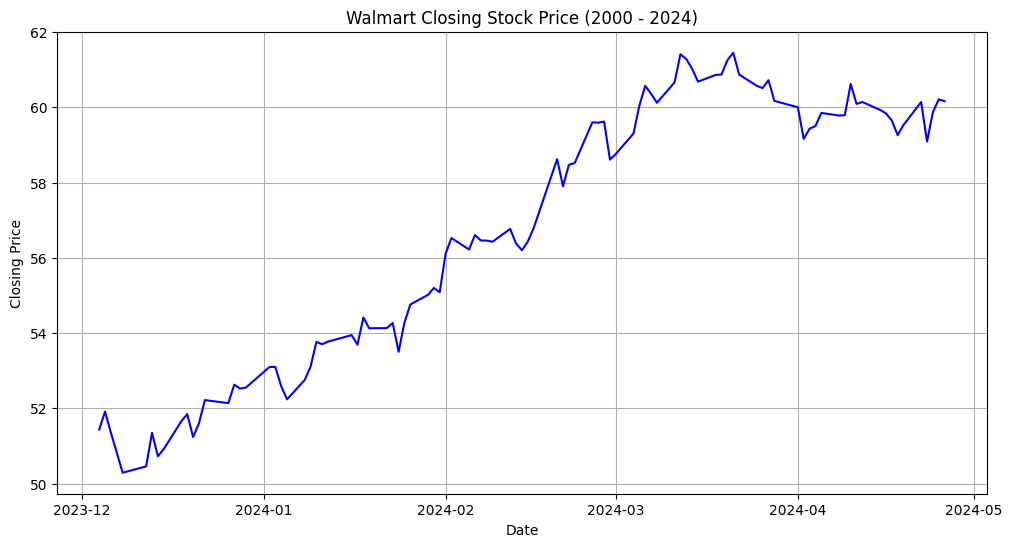

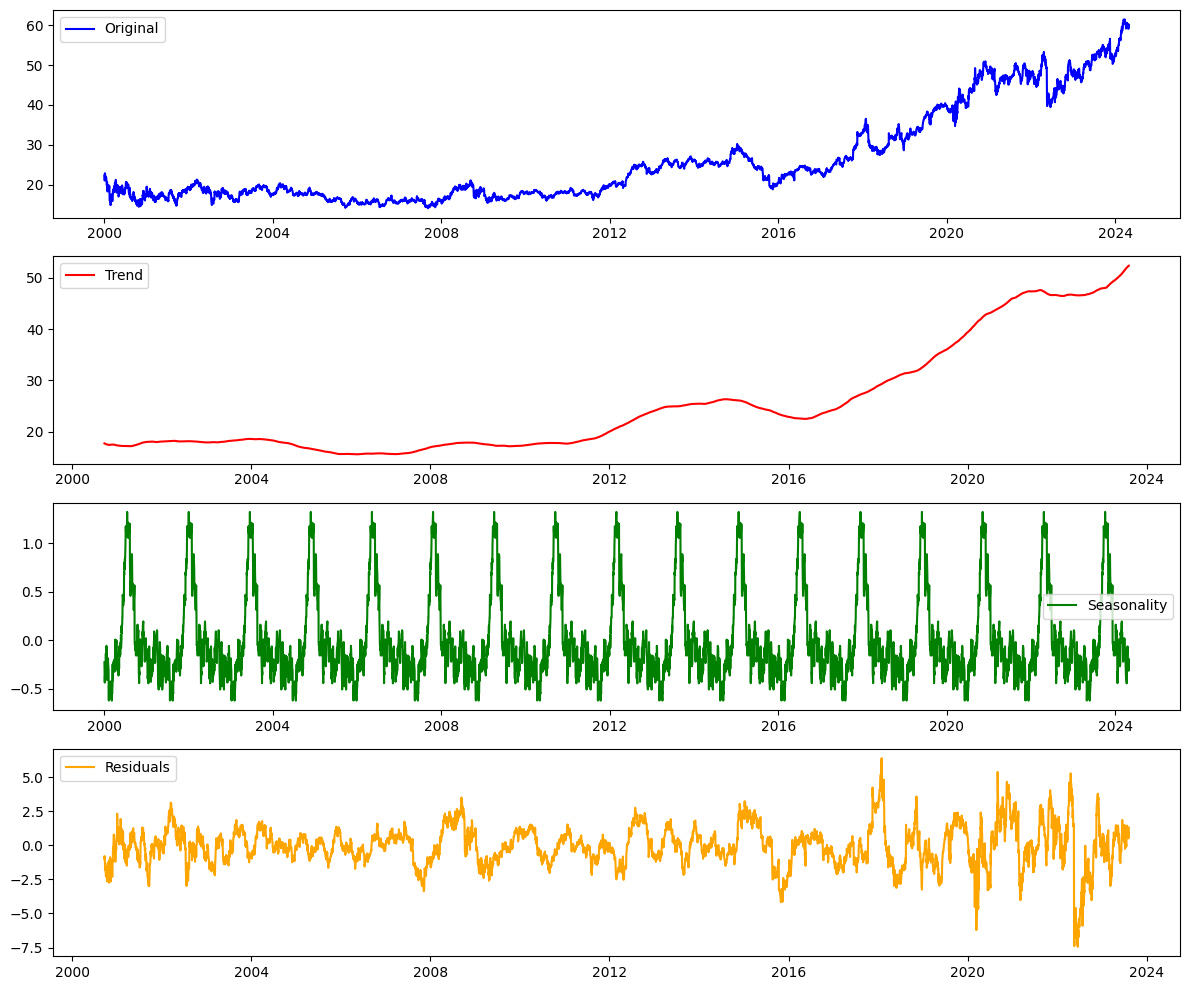

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'].tail(100), color='blue')
plt.title('Walmart Closing Stock Price (2000 - 2024)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

decomposition = seasonal_decompose(data['Close'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(data['Close'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='orange')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



In [ ]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

test_stationarity(data['Close'])


ADF Statistic: 1.2545247034436955
p-value: 0.9963417730347857
The time series is not stationary.


ADF Statistic: -16.162791797233602
p-value: 4.447653675704567e-29
The time series is stationary.


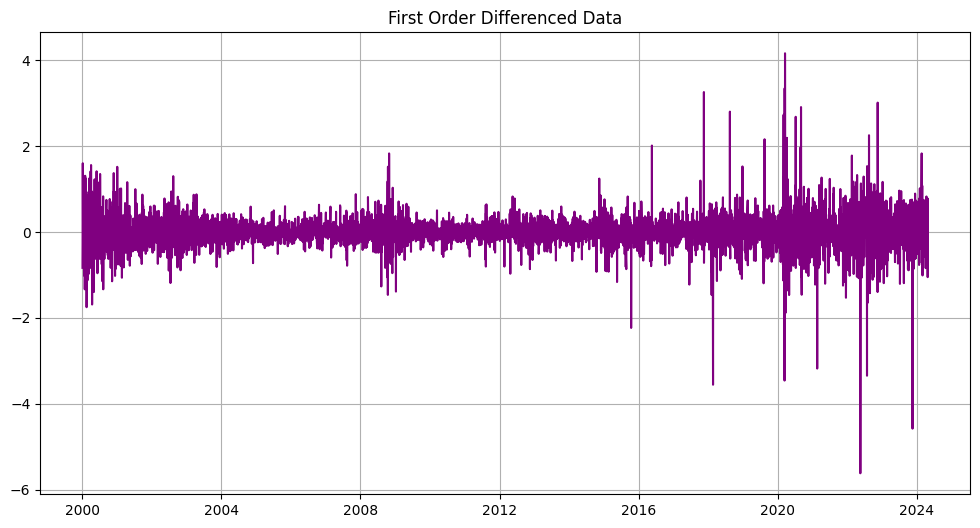

In [ ]:
data['Close_Diff'] = data['Close'].diff()
data.dropna(inplace=True)
test_stationarity(data['Close_Diff'])

plt.figure(figsize=(12, 6))
plt.plot(data['Close_Diff'], color='purple')
plt.title('First Order Differenced Data')
plt.grid(True)
plt.show()


In [62]:
data.index = pd.to_datetime(data.index)


In [ ]:
data = data.asfreq(pd.infer_freq(data.index))

In [ ]:
train_size = int(len(data['Close']) * 0.8)
train, test = data['Close'][:train_size], data['Close'][train_size:]

In [65]:
p, d, q = 1, 1, 1
model_arima = ARIMA(train, order=(p, d, q))
results_arima = model_arima.fit()

In [66]:
forecast_arima = results_arima.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

In [67]:
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12
model_sarima = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
results_sarima = model_sarima.fit()

In [68]:
forecast_sarima = results_sarima.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

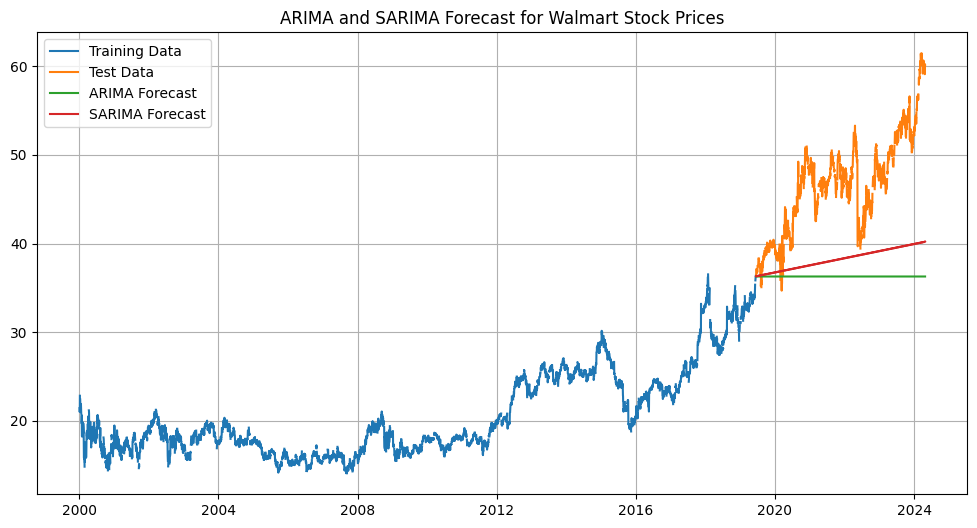

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(forecast_arima, label='ARIMA Forecast')
plt.plot(forecast_sarima, label='SARIMA Forecast')
plt.title('ARIMA and SARIMA Forecast for Walmart Stock Prices')
plt.grid(True)
plt.legend()
plt.show()

# Random Forest Model On Walmart Stock Dataset

In [103]:
data = pd.read_csv('WMT.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/3/2000,22.791668,23.000000,21.833332,22.270832,14.469358,25109700
1,1/4/2000,21.833332,21.937500,21.395832,21.437500,13.927947,20235300
2,1/5/2000,21.291668,21.458332,20.729168,21.000000,13.643703,21056100
3,1/6/2000,21.000000,21.520832,20.895832,21.229168,13.792585,19633500
4,1/7/2000,21.500000,22.979168,21.500000,22.833332,14.834813,23930700


In [104]:

X = data.drop(columns=['Date', 'Close'])  
y = data['Close'] 

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [106]:
print('Random Forest Regressor Train Score is : ' ,  rf_model.score(X_train, y_train))
print('Random Forest Regressor Test Score is : ' , rf_model.score(X_test, y_test))


Random Forest Regressor Train Score is :  0.9999779149817004
Random Forest Regressor Test Score is :  0.9998593467856908


In [107]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.01821350297785308
